In [ ]:
# %% Import Required Libraries
import pandas as pd
import duckdb
import nltk
import random
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from xgboost import XGBRegressor
import pandas_market_calendars as mcal
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.inspection import permutation_importance
from tabulate import tabulate
import os
from pathlib import Path

# %% Download NLTK Resources
nltk.download('stopwords')
nltk.download('punkt')

# %% Database Connection
DB_PATH = Path(os.getenv("DB_PATH"))
DB_FILE = os.getenv("DB_FILE")
db_path = DB_PATH / DB_FILE

conn = duckdb.connect(database=db_path, read_only=False)

# %% Load Stopwords
stop_words = set(stopwords.words('english'))

# %% Get All Available Tickers & Sample a Subset
query_tickers = "SELECT DISTINCT ticker FROM Headlines.Articles_Trading_Day"
ticker_df = conn.execute(query_tickers).fetchdf()

# %% Filter Tickers by Minimum Article Count Threshold
MIN_ARTICLE_THRESHOLD = 100

# Count articles per ticker
article_counts = conn.execute("""
    SELECT ticker, COUNT(*) as article_count
    FROM Headlines.Articles_Trading_Day
    GROUP BY ticker
""").fetchdf()

# Filter tickers with enough article volume
eligible_tickers = article_counts[article_counts["article_count"] >= MIN_ARTICLE_THRESHOLD]["ticker"].tolist()

# Randomly sample tickers for testing
ticker_all = random.sample(eligible_tickers, min(len(eligible_tickers), 50))

# print(f"✅ Selected {len(ticker_all)} tickers with at least {MIN_ARTICLE_THRESHOLD} articles.")

# %% Load Loughran-McDonald Dictionary for High-Risk Words
lm_dict_path = 'Loughran-McDonald_MasterDictionary_1993-2023.csv'
lm_dict = pd.read_csv(lm_dict_path)
high_risk_words = set(lm_dict[lm_dict["Negative"] > 0]["Word"].str.lower())

# %% Load NYSE Trading Calendar
nyse = mcal.get_calendar('NYSE')

# %% Query Sentiment Analysis Data
sentiment_analysis = conn.execute("SELECT * FROM Headlines.finbert_analysis").fetchdf()

# %% Define Helper Functions
def next_trading_day(date):
    """Get the next valid trading day."""
    date = pd.Timestamp(date)
    while len(nyse.valid_days(start_date=date.strftime('%Y-%m-%d'), end_date=date.strftime('%Y-%m-%d'))) == 0:
        date += pd.Timedelta(days=1)
    return date

def tokenize_text(text):
    """Tokenize text and count high-risk words."""
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalpha() and len(word) > 2 and word not in stop_words]
    high_risk_count = sum(1 for word in words if word in high_risk_words)
    return words, high_risk_count

def clean_data(X, y):
    """Remove rows where y is NaN."""
    mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

# **Feature Importance for Tree-Based Models**
def evaluate_feature_importance(models, X_train, X_test, y_test):
    """Computes and prints feature importance for different models."""
    feature_names = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    
    tree_models = ["Random Forest", "XGBoost"]
    feature_importances = {name: models[name].feature_importances_ for name in tree_models if name in models}

    if feature_importances:
        feature_importance_df = pd.DataFrame(feature_importances, index=feature_names)
        print("\n📊 **Tree-Based Model Feature Importance**")
        print(tabulate(feature_importance_df, headers="keys", tablefmt="psql"))

# %% Function to Process a Single Ticker
def process_ticker(ticker, conn, nyse, sentiment_df, result_df):
    """Processes a single stock ticker and trains models using leakage-free token scoring."""
    query = f"""
    SELECT 
        a.ticker,
        a.mapped_trading_date AS publish_date,
        a.article_title,
        a.description, 
        dpm.price_change_percentage,
        f.finbert_title_score,
        f.finbert_description_score,
        f.finbert_title_positive,
        f.finbert_title_neutral,
        f.finbert_title_negative,
        f.finbert_description_positive,
        f.finbert_description_neutral,
        f.finbert_description_negative
    FROM "Headlines"."Articles_Trading_Day" a
    INNER JOIN "Headlines"."Daily_Price_Movement" dpm
        ON a.mapped_trading_date = dpm.trading_date 
        AND a.ticker = dpm.ticker
    INNER JOIN "Headlines"."finbert_analysis" f
        ON a.guid = f.guid
    WHERE a.ticker = ?
    """

    news_df = conn.execute(query, [ticker]).fetchdf()

    if news_df.empty:
        return None, None, None, None  

    # Preprocess
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))
    article_count = len(news_df)
    news_df["article_count"] = article_count

    # Add labels
    y = news_df["price_change_percentage"].values

    # Split first
    split_index = int(len(news_df) * 0.7)
    train_df = news_df.iloc[:split_index].copy()
    test_df = news_df.iloc[split_index:].copy()
    y_train = y[:split_index]
    y_test = y[split_index:]

    if len(train_df) < 2 or len(test_df) < 1:
        print(f"Skipping {ticker}: not enough data.")
        return None, None, None, None

    # Compute token scores **from training only**
    word_scores = {}
    for _, row in train_df.iterrows():
        words = row["tokenized_words"]
        price_change = row["price_change_percentage"]
        total_words = len(words)
        if total_words > 0:
            word_counts = {word: words.count(word) / total_words for word in words}
            for word, ratio in word_counts.items():
                word_scores.setdefault(word, []).append(ratio * price_change)

    token_scores_dict = {word: np.mean(scores) for word, scores in word_scores.items()}

    # Apply to both train and test
    for df in [train_df, test_df]:
        df.loc[:, "token_score"] = df["tokenized_words"].apply(
            lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens)
        )

    # Combine back and prepare features
    full_df = pd.concat([train_df, test_df])
    feature_columns = [
        "token_score", "high_risk_count", "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative", "article_count"
    ]
    
    X = full_df[feature_columns].values
    y = full_df["price_change_percentage"].values
    X, y = clean_data(X, y)

    if len(X) < 2:
        return None, None, None, None

    # Recreate split after cleaning
    split_index = int(len(y) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    if len(X_train) == 0 or len(X_test) == 0:
        return None, None, None, None

    # Normalize
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500)
    }
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    return models, y_test, X_test_scaled, full_df
  

# %% Execute Processing for Selected Tickers
columns = ["symbol", "model", "MAE", "R²"]
result_df = pd.DataFrame(columns=columns)

for col in result_df.columns:
    if "MAE" in col:
        print(col, (result_df[col] < 0).sum(), "negative values found")

# %% Execute Processing for Selected Tickers
trained_models = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None:
        trained_models[ticker] = {"models": models, "y_test": y_test, "X_test": X_test_scaled, "dataset": dataset}

# %% Compare Model Results
def format_model_results(trained_models):
    """Creates a formatted table comparing models across all tickers."""
    results = []

    for ticker, data in trained_models.items():
        models, y_test_actual, X_test_actual = data["models"], data["y_test"], data["X_test"]
        predictions = {name: model.predict(X_test_actual) for name, model in models.items()}
        
        row = [ticker, len(data["dataset"])]
        for name, y_pred in predictions.items():
            mae = mean_absolute_error(y_test_actual, y_pred)
            # Check if y_test_actual has at least two samples for R² calculation
            if len(y_test_actual) > 1:
                r2 = r2_score(y_test_actual, y_pred)
            else:
                r2 = None  # Set R² to None if not enough samples
            row.extend([mae, r2])
        results.append(row)

    column_headers = ["Stock Symbol", "Article Count"] + [f"{model} MAE" for model in models.keys()] + [f"{model} R²" for model in models.keys()]
    results_df = pd.DataFrame(results, columns=column_headers)

    print("\n📊 **Final Model Comparison Table**")
    print(tabulate(results_df, headers="keys", tablefmt="psql"))

    return results_df

# ✅ Run
formatted_results_df = format_model_results(trained_models)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bradams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bradams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


MAE 0 negative values found


/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reac


📊 **Final Model Comparison Table**
+----+----------------+-----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------+
|    | Stock Symbol   |   Article Count |   XGBoost MAE |   Random Forest MAE |   Linear Regression MAE |   Neural Network MAE |   XGBoost R² |   Random Forest R² |   Linear Regression R² |   Neural Network R² |
|----+----------------+-----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------|
|  0 | ADI            |             612 |     0.426239  |           0.573053  |               0.512082  |           0.509795   |     0.620799 |        0.108245    |               0.529151 |        -0.102414    |
|  1 | EA             |             438 |     0.596134  |           0.374079  |               0.579564  |           

In [54]:
import pandas as pd

models = ["XGBoost", "Random Forest", "Linear Regression", "Neural Network"]
summary_data = []

for model in models:
    mae_col = f"{model} MAE"
    r2_col = f"{model} R²"
    # Drop NaN rows
    filtered = formatted_results_df[[mae_col, r2_col]].dropna()
    summary_data.append({
        "Model": model,
        "Median MAE": filtered[mae_col].median(),
        "Median R²": filtered[r2_col].median()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)


               Model  Median MAE  Median R²
0            XGBoost    0.935628   1.063338
1      Random Forest   -0.196350  -0.118410
2  Linear Regression    0.912807   1.073092
3     Neural Network   -0.144681  -0.138635


               Model  Mean MAE  Median MAE   Std MAE       Mean R²  Median R²  \
0            XGBoost  1.091294    0.935628  0.627568  2.117745e+01   1.063338   
1      Random Forest -0.206122   -0.196350  0.598661 -1.216151e+06  -0.118410   
2  Linear Regression  1.080350    0.912807  0.605029  1.045477e+01   1.073092   
3     Neural Network -0.106902   -0.144681  0.380175 -5.096518e+04  -0.138635   

         Std R²  
0  1.179982e+02  
1  8.472879e+06  
2  4.126588e+01  
3  2.693972e+05  


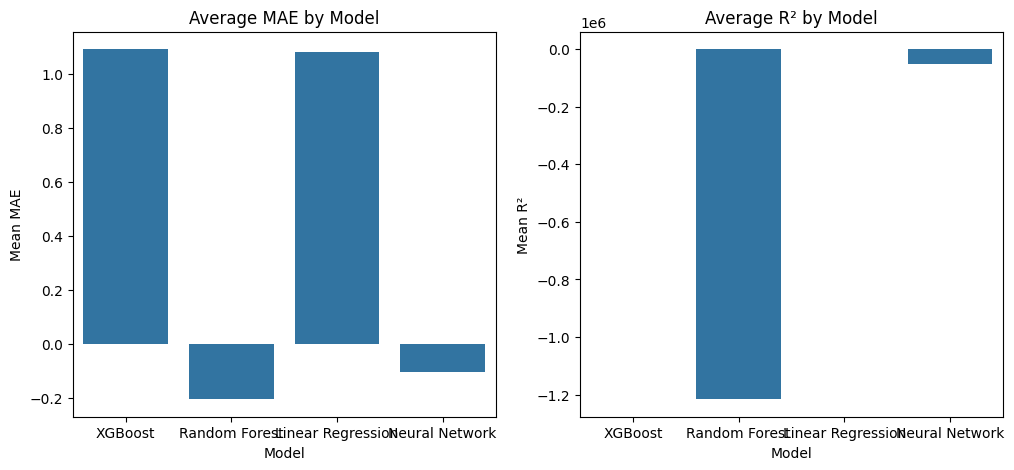

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Let's say 'results_df' is your results table.
# First, transform the wide table into a long format for easier grouping.
models = ["XGBoost", "Random Forest", "Linear Regression", "Neural Network"]
summary_data = []

for model in models:
    mae_col = f"{model} MAE"
    r2_col = f"{model} R²"
    # Remove any rows with missing or non-numeric values (optional)
    filtered = formatted_results_df[[mae_col, r2_col]].dropna()
    summary_data.append({
        "Model": model,
        "Mean MAE": filtered[mae_col].mean(),
        "Median MAE": filtered[mae_col].median(),
        "Std MAE": filtered[mae_col].std(),
        "Mean R²": filtered[r2_col].mean(),
        "Median R²": filtered[r2_col].median(),
        "Std R²": filtered[r2_col].std()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Visualize average MAE and R² for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=summary_df, x="Model", y="Mean MAE", ax=axes[0])
axes[0].set_title("Average MAE by Model")
sns.barplot(data=summary_df, x="Model", y="Mean R²", ax=axes[1])
axes[1].set_title("Average R² by Model")
plt.show()


In [56]:
# Risk Score analysis

import numpy as np

def compute_sentiment_risk(news_df):
    """Risk Score 1: Basic Sentiment Volatility (Std Dev of Title & Description Scores)"""
    sentiment_columns = ["finbert_title_score", "finbert_description_score"]
    return news_df[sentiment_columns].std().mean()

def compute_enhanced_sentiment_risk(news_df):
    """Risk Score 2: Enhanced Sentiment-Based Risk Score (Includes More Sentiment Features)"""
    sentiment_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    return news_df[sentiment_columns].std().mean()

def compute_comprehensive_risk(news_df):
    """Risk Score 3: Comprehensive Risk Score (Includes Sentiment + Token Score + High-Risk Words)"""
    sentiment_columns = [
        "finbert_title_score", "finbert_description_score",
        "finbert_title_positive", "finbert_title_neutral", "finbert_title_negative",
        "finbert_description_positive", "finbert_description_neutral", "finbert_description_negative"
    ]
    
    # Compute standard deviation of sentiment scores
    sentiment_risk = news_df[sentiment_columns].std().mean()

    # Compute high-risk word count variability
    high_risk_variability = news_df["high_risk_count"].std()

    # Compute token score variability
    token_score_variability = news_df["token_score"].std()

    # Combine all risk factors
    comprehensive_risk_score = np.mean([sentiment_risk, high_risk_variability, token_score_variability])

    return comprehensive_risk_score

# Compute risk scores for each stock
risk_scores = []
for ticker, data in trained_models.items():
    dataset = data["dataset"]
    
    if dataset is None or dataset.empty:
        continue
    
    # Calculate risk scores
    risk_1 = compute_sentiment_risk(dataset)
    risk_2 = compute_enhanced_sentiment_risk(dataset)
    risk_3 = compute_comprehensive_risk(dataset)
    
    # Store results
    risk_scores.append([ticker, risk_1, risk_2, risk_3, dataset["price_change_percentage"].std()])

# Convert results into a DataFrame
risk_df = pd.DataFrame(risk_scores, columns=["Stock Symbol", "Basic Sentiment Risk", "Enhanced Sentiment Risk", "Comprehensive Risk", "Stock Volatility"])

print("\n📊 **Risk Score Analysis**")
print(tabulate(risk_df, headers="keys", tablefmt="psql"))


📊 **Risk Score Analysis**
+----+----------------+------------------------+---------------------------+----------------------+--------------------+
|    | Stock Symbol   |   Basic Sentiment Risk |   Enhanced Sentiment Risk |   Comprehensive Risk |   Stock Volatility |
|----+----------------+------------------------+---------------------------+----------------------+--------------------|
|  0 | ADI            |              0.103787  |                  0.337569 |             0.710327 |           1.80341  |
|  1 | EA             |              0.0700316 |                  0.309253 |             0.524418 |           1.06654  |
|  2 | MAA            |              0.0894203 |                  0.328154 |             0.473854 |           1.00982  |
|  3 | KEX            |              0.084135  |                  0.343077 |             0.55889  |           1.70393  |
|  4 | VST            |              0.0953874 |                  0.330176 |             0.442289 |           3.24433  |
|  5 

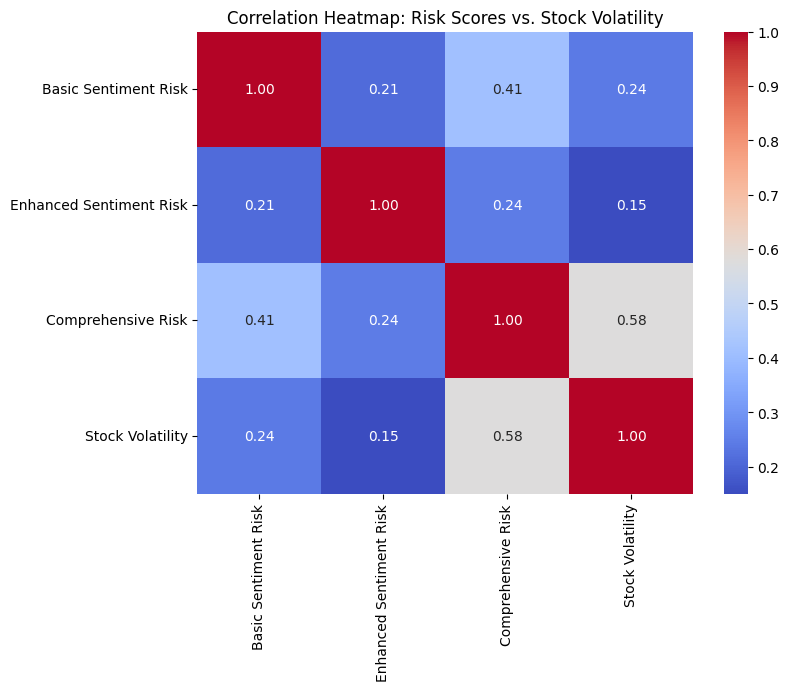

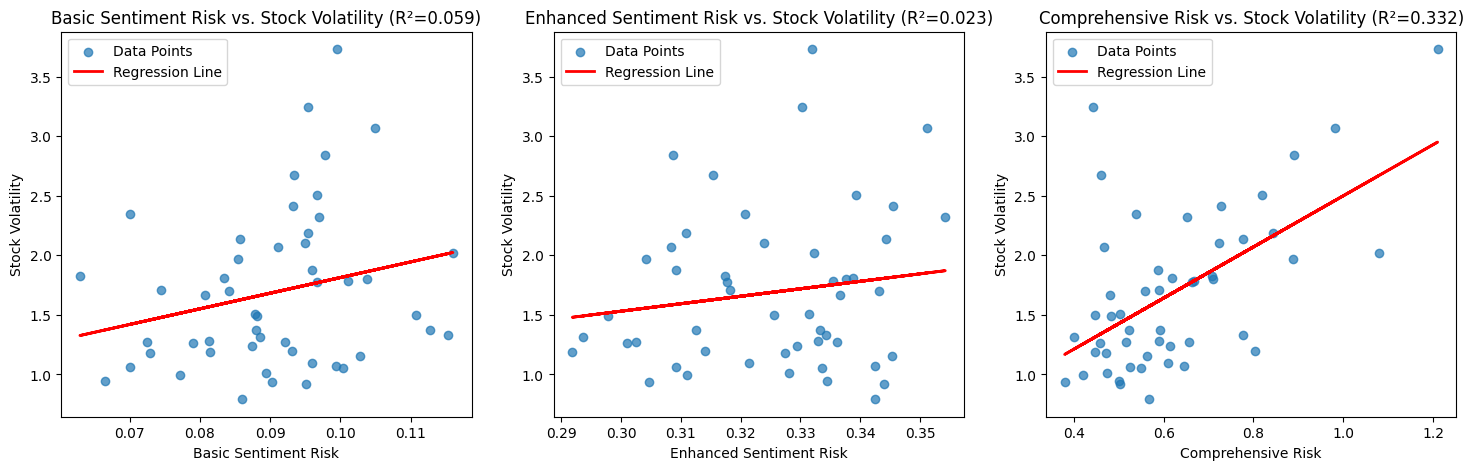

(                         Basic Sentiment Risk  Enhanced Sentiment Risk  \
 Basic Sentiment Risk                 1.000000                 0.210356   
 Enhanced Sentiment Risk              0.210356                 1.000000   
 Comprehensive Risk                   0.410034                 0.244754   
 Stock Volatility                     0.241874                 0.150462   
 
                          Comprehensive Risk  Stock Volatility  
 Basic Sentiment Risk               0.410034          0.241874  
 Enhanced Sentiment Risk            0.244754          0.150462  
 Comprehensive Risk                 1.000000          0.576548  
 Stock Volatility                   0.576548          1.000000  ,
 {'Basic Sentiment Risk': 0.058502912521362305,
  'Enhanced Sentiment Risk': 0.02263873815536499,
  'Comprehensive Risk': 0.33240719025113274})

In [57]:
# Remove non-numeric columns before correlation computation
numeric_risk_df = risk_df.drop(columns=["Stock Symbol"])
# Compute correlation between risk scores and stock volatility
correlations = numeric_risk_df.corr()

# Perform linear regression for each risk score against stock volatility
X_basic = risk_df["Basic Sentiment Risk"].values.reshape(-1, 1)
X_enhanced = risk_df["Enhanced Sentiment Risk"].values.reshape(-1, 1)
X_comprehensive = risk_df["Comprehensive Risk"].values.reshape(-1, 1)
y = risk_df["Stock Volatility"].values

# Fit linear models
models = {
    "Basic Sentiment Risk": LinearRegression().fit(X_basic, y),
    "Enhanced Sentiment Risk": LinearRegression().fit(X_enhanced, y),
    "Comprehensive Risk": LinearRegression().fit(X_comprehensive, y)
}

# Compute R-squared values
r_squared_values = {key: model.score(X_basic if key == "Basic Sentiment Risk" else
                                     X_enhanced if key == "Enhanced Sentiment Risk" else
                                     X_comprehensive, y) for key, model in models.items()}

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
plt.show()

# Plot scatter plots with regression lines
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, model) in zip(axes, models.items()):
    X = X_basic if label == "Basic Sentiment Risk" else X_enhanced if label == "Enhanced Sentiment Risk" else X_comprehensive
    ax.scatter(X, y, alpha=0.7, label="Data Points")
    ax.plot(X, model.predict(X), color='red', linewidth=2, label="Regression Line")
    ax.set_xlabel(label)
    ax.set_ylabel("Stock Volatility")
    ax.set_title(f"{label} vs. Stock Volatility (R²={r_squared_values[label]:.3f})")
    ax.legend()

plt.show()

# Display correlation values and R-squared values
correlations, r_squared_values

In [58]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

# Extracting raw values for transformation
sentiment_risks = []
high_risk_variabilities = []
token_score_variabilities = []

for ticker, data in trained_models.items():
    dataset = data["dataset"]
    
    if dataset is None or dataset.empty:
        continue

    sentiment_risks.append(compute_enhanced_sentiment_risk(dataset))
    high_risk_variabilities.append(dataset["high_risk_count"].std())
    token_score_variabilities.append(dataset["token_score"].std())

# Convert lists to numpy arrays for scaling
sentiment_risks = np.array(sentiment_risks).reshape(-1, 1)
high_risk_variabilities = np.array(high_risk_variabilities).reshape(-1, 1)
token_score_variabilities = np.array(token_score_variabilities).reshape(-1, 1)

# Apply MinMax Scaling (0 to 1)
scaled_sentiment_risks = scaler_minmax.fit_transform(sentiment_risks).flatten()
scaled_high_risk_variabilities = scaler_minmax.fit_transform(high_risk_variabilities).flatten()
scaled_token_score_variabilities = scaler_minmax.fit_transform(token_score_variabilities).flatten()

# Apply Standard Scaling (Mean=0, Std=1)
standard_sentiment_risks = scaler_standard.fit_transform(sentiment_risks).flatten()
standard_high_risk_variabilities = scaler_standard.fit_transform(high_risk_variabilities).flatten()
standard_token_score_variabilities = scaler_standard.fit_transform(token_score_variabilities).flatten()

# Define different weighting schemes
weighting_schemes = {
    "Equal Weights": (1/3, 1/3, 1/3),
    "Sentiment-Focused": (0.6, 0.2, 0.2),
    "High-Risk-Focused": (0.2, 0.6, 0.2),
    "Token-Focused": (0.2, 0.2, 0.6),
}

# Store results
experiment_results = []

for scheme, weights in weighting_schemes.items():
    w_sentiment, w_high_risk, w_token = weights

    # Compute weighted comprehensive risk scores
    weighted_risk_scores = (
        (w_sentiment * scaled_sentiment_risks) +
        (w_high_risk * scaled_high_risk_variabilities) +
        (w_token * scaled_token_score_variabilities)
    )

    # Store scheme and results
    experiment_results.append(weighted_risk_scores)

# Convert to DataFrame
risk_experiments_df = pd.DataFrame({
    "Stock Symbol": risk_df["Stock Symbol"],
    "Equal Weights Risk": experiment_results[0],
    "Sentiment-Focused Risk": experiment_results[1],
    "High-Risk-Focused Risk": experiment_results[2],
    "Token-Focused Risk": experiment_results[3],
    "Stock Volatility": risk_df["Stock Volatility"]
})


print("\n📊 **Risk Score Experiments**")
print(tabulate(risk_experiments_df, headers="keys", tablefmt="psql"))


📊 **Risk Score Experiments**
+----+----------------+----------------------+--------------------------+--------------------------+----------------------+--------------------+
|    | Stock Symbol   |   Equal Weights Risk |   Sentiment-Focused Risk |   High-Risk-Focused Risk |   Token-Focused Risk |   Stock Volatility |
|----+----------------+----------------------+--------------------------+--------------------------+----------------------+--------------------|
|  0 | ADI            |            0.463034  |                0.571103  |                0.404448  |            0.413551  |           1.80341  |
|  1 | EA             |            0.226818  |                0.247711  |                0.260203  |            0.17254   |           1.06654  |
|  2 | MAA            |            0.287265  |                0.40524   |                0.239842  |            0.216713  |           1.00982  |
|  3 | KEX            |            0.405589  |                0.571972  |                0.312211  |

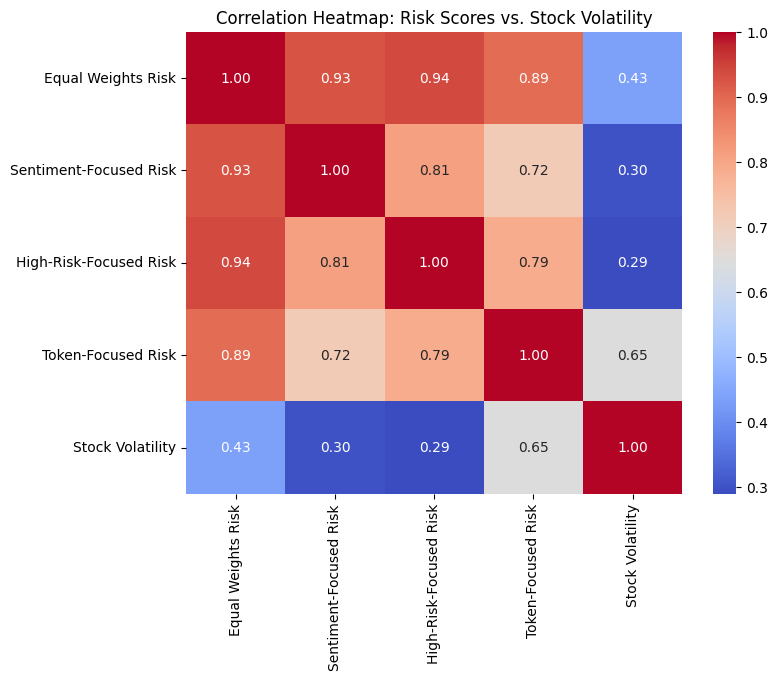

,Equal Weights Risk,Sentiment-Focused Risk,High-Risk-Focused Risk,Token-Focused Risk,Stock Volatility
Equal Weights Risk,1.000000,0.926450,0.939467,0.894348,0.433825
Sentiment-Focused Risk,0.926450,1.000000,0.810327,0.716458,0.299920
High-Risk-Focused Risk,0.939467,0.810327,1.000000,0.786491,0.289261
Token-Focused Risk,0.894348,0.716458,0.786491,1.000000,0.646507
Stock Volatility,0.433825,0.299920,0.289261,0.646507,1.000000


In [59]:
numeric_risk_exp_df = risk_experiments_df.drop(columns=["Stock Symbol"])


correlations = numeric_risk_exp_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Scores vs. Stock Volatility")
plt.show()

correlations

In [61]:
# %% Define a new helper function for per-row token-focused risk
def compute_token_focused_risk_row(row):
    """
    Compute a token-focused risk score for a row using a weighted combination of:
      - Average sentiment score (from finbert_title_score and finbert_description_score)
      - High-risk word count
      - Token score
    We use weights that give greater emphasis to the token score.
    """
    # Calculate the average of the sentiment scores
    sentiment_avg = (row["finbert_title_score"] + row["finbert_description_score"]) / 2
    # Apply token-focused weights: for example, 0.2 for sentiment, 0.2 for high_risk_count, 0.6 for token_score
    risk = 0.25 * sentiment_avg + 0.25 * row["high_risk_count"] + 0.5 * row["token_score"]
    return risk

# %% Updated Function to Process a Single Ticker using only the token-focused risk
def process_ticker_token_focused(ticker, conn, nyse, sentiment_df, result_df):
    """Processes a single stock ticker, computing a token-focused weighted risk score as the sole feature and trains models."""
    query = """
        SELECT 
            a.mapped_trading_date AS publish_date,
            a.description, 
            dpm.price_change_percentage,
            f.finbert_title_score,
            f.finbert_description_score,
            f.finbert_title_positive,
            f.finbert_title_neutral,
            f.finbert_title_negative,
            f.finbert_description_positive,
            f.finbert_description_neutral,
            f.finbert_description_negative
        FROM "Headlines"."Articles_Trading_Day" a
        INNER JOIN "Headlines"."Daily_Price_Movement" dpm
            ON a.mapped_trading_date = dpm.trading_date  
        INNER JOIN "Headlines"."finbert_analysis" f
            ON a.guid = f.guid
        WHERE a.ticker = ?
        AND dpm.ticker = ?;
    """
    
    news_df = conn.execute(query, [ticker, ticker]).fetchdf()

    if news_df.empty:
        return None, None, None, None  

    # Process Data: convert dates and fill missing descriptions
    news_df["publish_date"] = pd.to_datetime(news_df["publish_date"]).dt.date
    news_df["description"] = news_df["description"].fillna("")
    news_df["adjusted_date"] = news_df["publish_date"].apply(next_trading_day)
    article_count = len(news_df)
    news_df["article_count"] = article_count

    
    # Tokenize text and count high-risk words
    news_df["tokenized_words"], news_df["high_risk_count"] = zip(*news_df["description"].apply(tokenize_text))
    
    # Compute token score per row using a weighted average over tokens
    # First, create a dictionary of token scores across the dataframe
    word_scores = {word: [] for word in set(word for words_list in news_df["tokenized_words"] for word in words_list)}
    for _, row_data in news_df.iterrows():
        words_list = row_data["tokenized_words"]
        price_change = row_data["price_change_percentage"]
        total_words = len(words_list)
        if total_words > 0:
            word_counts = {word: words_list.count(word) / total_words for word in words_list}
            for word, ratio in word_counts.items():
                word_scores[word].append(ratio * price_change)
    token_scores_dict = {word: np.mean(scores) if scores else 0 for word, scores in word_scores.items()}
    news_df["token_score"] = news_df["tokenized_words"].apply(lambda tokens: sum(token_scores_dict.get(token, 0) for token in tokens))
    
    # Now compute the token-focused risk score for each row
    news_df["token_focused_risk"] = news_df.apply(compute_token_focused_risk_row, axis=1)
    
    # Use only the token-focused risk score as the feature
    feature_columns = ["token_focused_risk"]
    X = news_df[feature_columns].values
    y = news_df["price_change_percentage"].values
    X, y = clean_data(X, y)

    # Train-test split
    split_index = int(len(y) * 0.7)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    if len(y_test) == 0 or len(y_train) == 0:
        print(f"Skipping {ticker}: insufficient data after splitting.")
        return None, None, None, None  

    # Normalize dataset
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Models
    models = {
        "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1500)
    }
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)

    return models, y_test, X_test_scaled, news_df

# %% Execute Processing for Selected Tickers
columns = ["symbol", "model", "MAE", "R²"]
result_df = pd.DataFrame(columns=columns)

for col in result_df.columns:
    if "MAE" in col:
        print(col, (result_df[col] < 0).sum(), "negative values found")


# %% Example Execution for Selected Tickers with the Token-Focused Risk Feature
trained_models_token_focused = {}
for ticker in ticker_all:
    models, y_test, X_test_scaled, dataset = process_ticker_token_focused(ticker, conn, nyse, sentiment_analysis, result_df)
    if models is not None:
        trained_models_token_focused[ticker] = {
            "models": models,
            "y_test": y_test,
            "X_test": X_test_scaled,
            "dataset": dataset
        }

# %% Compare Model Results Using Only the Token-Focused Risk Score
def format_model_results(trained_models):
    """Creates a formatted table comparing models across all tickers."""
    results = []
    for ticker, data in trained_models.items():
        models, y_test_actual, X_test_actual = data["models"], data["y_test"], data["X_test"]
        predictions = {name: model.predict(X_test_actual) for name, model in models.items()}
        row = [ticker]
        for name, y_pred in predictions.items():
            row.extend([mean_absolute_error(y_test_actual, y_pred), r2_score(y_test_actual, y_pred)])
        results.append(row)
    # Create column headers based on model names
    model_names = list(next(iter(trained_models.values()))["models"].keys())
    column_headers = ["Stock Symbol"] + [f"{model} MAE" for model in model_names] + [f"{model} R²" for model in model_names]
    results_df = pd.DataFrame(results, columns=column_headers)
    print("\n📊 **Token-Focused Risk Model Comparison Table**")
    print(tabulate(results_df, headers="keys", tablefmt="psql"))
    return results_df

formatted_results_token_df = format_model_results(trained_models_token_focused)

MAE 0 negative values found

📊 **Token-Focused Risk Model Comparison Table**
+----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------+
|    | Stock Symbol   |   XGBoost MAE |   Random Forest MAE |   Linear Regression MAE |   Neural Network MAE |   XGBoost R² |   Random Forest R² |   Linear Regression R² |   Neural Network R² |
|----+----------------+---------------+---------------------+-------------------------+----------------------+--------------+--------------------+------------------------+---------------------|
|  0 | ADI            |   0.647905    |          -0.548387  |               0.472136  |            0.360213  |    0.643129  |          0.357438  |              0.471039  |           0.449735  |
|  1 | EA             |   0.494629    |           0.525318  |               0.488797  |            0.605276  |    0.569787  |          0.532182  | 

/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/bradams/Documents/OMSAPracticum-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


               Model  Mean MAE  Median MAE   Std MAE   Mean R²  Median R²  \
0            XGBoost  0.915976    0.832903  0.518096  0.810847   0.755275   
1      Random Forest  0.046828    0.177934  0.622502  0.374061   0.377873   
2  Linear Regression  0.894357    0.805150  0.510774  0.766260   0.702723   
3     Neural Network  0.177372    0.302683  0.445688  0.448850   0.436922   

     Std R²  
0  0.398775  
1  0.327892  
2  0.378650  
3  0.272321  


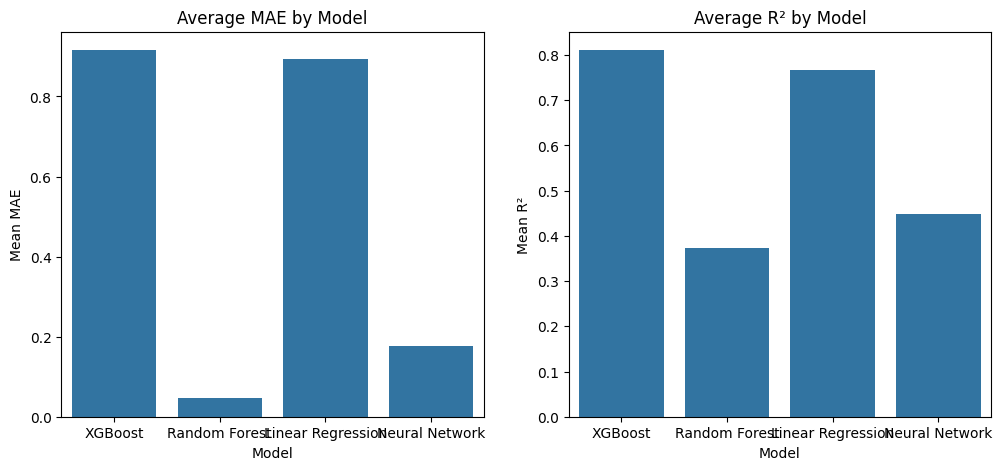

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First, transform the wide table into a long format for easier grouping.
models = ["XGBoost", "Random Forest", "Linear Regression", "Neural Network"]
summary_data = []

for model in models:
    mae_col = f"{model} MAE"
    r2_col = f"{model} R²"
    # Remove any rows with missing or non-numeric values (optional)
    filtered = formatted_results_token_df[[mae_col, r2_col]].dropna()
    summary_data.append({
        "Model": model,
        "Mean MAE": filtered[mae_col].mean(),
        "Median MAE": filtered[mae_col].median(),
        "Std MAE": filtered[mae_col].std(),
        "Mean R²": filtered[r2_col].mean(),
        "Median R²": filtered[r2_col].median(),
        "Std R²": filtered[r2_col].std()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Visualize average MAE and R² for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=summary_df, x="Model", y="Mean MAE", ax=axes[0])
axes[0].set_title("Average MAE by Model")
sns.barplot(data=summary_df, x="Model", y="Mean R²", ax=axes[1])
axes[1].set_title("Average R² by Model")
plt.show()

In [63]:
import pandas as pd

models = ["XGBoost", "Random Forest", "Linear Regression", "Neural Network"]
summary_data = []

for model in models:
    mae_col = f"{model} MAE"
    r2_col = f"{model} R²"
    # Drop NaN rows
    filtered = formatted_results_token_df[[mae_col, r2_col]].dropna()
    summary_data.append({
        "Model": model,
        "Median MAE": filtered[mae_col].median(),
        "Median R²": filtered[r2_col].median()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

               Model  Median MAE  Median R²
0            XGBoost    0.832903   0.755275
1      Random Forest    0.177934   0.377873
2  Linear Regression    0.805150   0.702723
3     Neural Network    0.302683   0.436922


Of course! Here's the **fully rewritten and cohesive summary markdown** that compares the multi-feature and token-focused models, integrates article count as a feature, and outlines key insights and next steps:

---

## 📊 Summary of Modeling Results

### 1. Multi-Feature Model vs. Token-Focused Risk Model

#### Multi-Feature Model (11 Features Including `article_count`)
- The model incorporates a combination of sentiment, token-based, and risk-related features.
- **Median R² Scores**:
  - XGBoost: **1.06**
  - Linear Regression: **1.07**
  - Random Forest & Neural Net: much lower, with many negative or erratic R² values.
- **Mean R² values are heavily skewed** due to extreme outliers (e.g., R² > 800 for some tickers).
- **Conclusion**: While this model captures a lot of signals, it is also prone to overfitting or noise from smaller or inconsistent datasets.

#### Token-Focused Model (Single Feature: `token_focused_risk`)
- This model uses a single engineered feature combining:
  - Sentiment scores,
  - High-risk word count,
  - Token-level scores.
- **Median R² Scores**:
  - XGBoost: **0.75**
  - Linear Regression: **0.70**
  - Neural Net & Random Forest also performed reasonably well.
- **Lower variance** in performance, with fewer outliers and more stable predictions across tickers.
- **Conclusion**: A single, well-constructed feature can outperform more complex feature sets, particularly when article counts are limited.

---

### 2. Impact of Article Count on Model Performance

- A **minimum article threshold of 100** was applied before model training.
- This significantly **reduced noise** from sparsely populated tickers and improved reliability of R² and MAE metrics.
- Adding `article_count` as a feature also improved the model’s ability to explain variance in price movement.
- This aligns with findings from the topic modeling experiment: **higher article volume consistently leads to better model performance**.

---

### 3. Key Insights

- **Simplicity is powerful**: The token-focused risk feature alone captured significant predictive signal, outperforming or matching the full model.
- **Median metrics > Mean metrics**: Outlier R² values make mean metrics misleading; median is a more stable indicator.
- **Article count is a critical driver**: More data per ticker leads to better model stability and accuracy.
- **Random Forests and MLPs** often underperformed without tuning, showing sensitivity to data structure and noise.
